
Environment Setup

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
import plotly.graph_objects as go

In [13]:
# Plot settings

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12,6)

In [25]:
# Load data
data_path = Path("../data/final/ibm_df.csv")
df = pd.read_csv(data_path, parse_dates=["Date"])
print(df.head(2))

        Date       Close   Volume    Return  Interest  Sentiment
0 2020-11-25  118.738052  4326151 -0.001768 -0.195876     0.0000
1 2020-11-27  118.881454  2187395  0.001208 -0.505155     0.4588



EDA

In [26]:
# Shape

rows, cols = df.shape
print(f"Dataset Shape: \n Rows={rows:,}, Columns={cols}")

Dataset Shape: 
 Rows=362, Columns=6


In [27]:
# Columns

print(df.columns.tolist())

['Date', 'Close', 'Volume', 'Return', 'Interest', 'Sentiment']


In [28]:
# Missing Values (should all be 0)
print("\nMissing values:\n", df.isna().sum())


Missing values:
 Date         0
Close        0
Volume       0
Return       0
Interest     0
Sentiment    0
dtype: int64


In [29]:
# Summary Stats

print(df.describe())

                                Date       Close        Volume      Return  \
count                            362  362.000000  3.620000e+02  362.000000   
mean   2023-02-19 01:15:34.806629888  160.446153  5.270017e+06    0.001272   
min              2020-11-25 00:00:00  113.393883  1.790400e+06   -0.099050   
25%              2021-11-03 06:00:00  128.217503  3.436975e+06   -0.006216   
50%              2023-02-25 00:00:00  137.530632  4.453030e+06    0.001419   
75%              2024-04-24 18:00:00  172.919998  5.713075e+06    0.008631   
max              2025-11-20 00:00:00  312.570007  3.981442e+07    0.129642   
std                              NaN   49.634107  3.577895e+06    0.017225   

         Interest   Sentiment  
count  362.000000  362.000000  
mean    -0.030871    0.032755  
min     -0.938144   -0.862500  
25%     -0.175258    0.000000  
50%     -0.072165    0.000000  
75%      0.175258    0.158833  
max      1.000000    0.822500  
std      0.400205    0.275264  


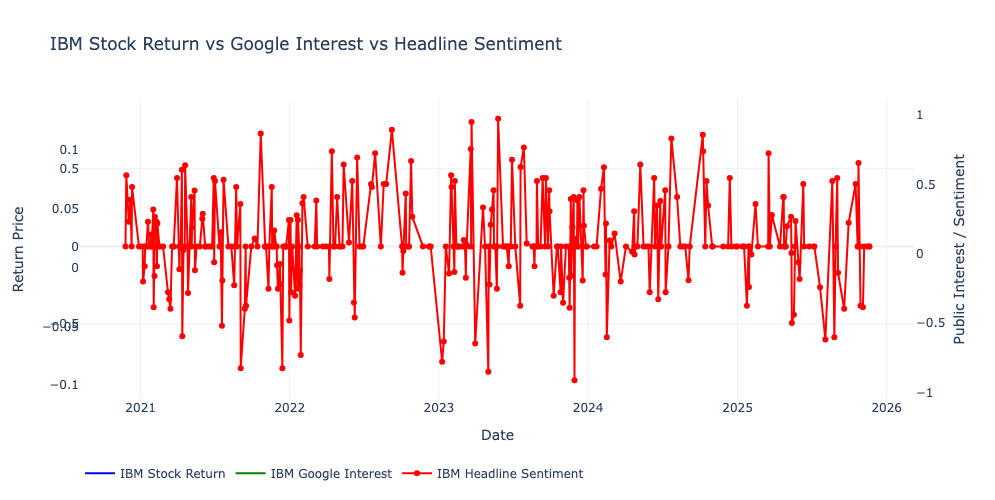

In [30]:
# Time Series

# Create figure
fig = go.Figure()

# Stock price
fig.add_trace(go.Scatter(
    x=df["Date"], y=df["Return"],
    mode="lines",
    name="IBM Stock Return",
    line=dict(color="blue")
))

# Google Interest
fig.add_trace(go.Scatter(
    x=df["Date"], y=df["Interest"],
    mode="lines",
    name="IBM Google Interest",
    yaxis="y2",
    line=dict(color="green")
))

# Sentiment
fig.add_trace(go.Scatter(
    x=df["Date"], y=df["Sentiment"],
    mode="lines+markers",
    name="IBM Headline Sentiment",
    yaxis="y3",
    line=dict(color="red")
))

# Layout with multiple y-axes
fig.update_layout(
    title="IBM Stock Return vs Google Interest vs Headline Sentiment",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Return Price", side="left"),
    yaxis2=dict(title="Public Interest / Sentiment", overlaying="y", side="right"),
    legend=dict(orientation="h", y=-0.2),
    template="plotly_white",
    width=1000, height=500
)

fig.show()


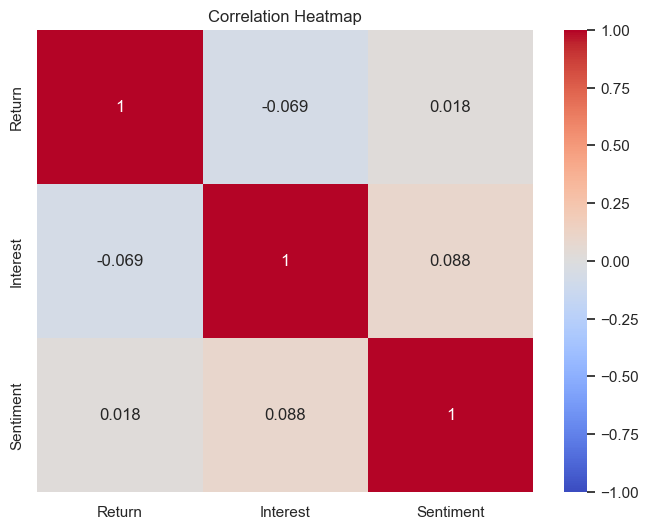

In [31]:
# Correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df[['Return', 'Interest', 'Sentiment']].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# plt.savefig("results/correlation_heatmap.png")

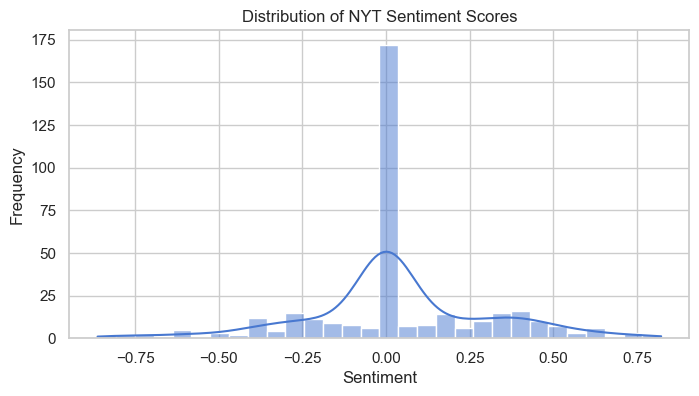

In [32]:
# Distribution of sentiment

plt.figure(figsize=(8, 4))
sns.histplot(df["Sentiment"], kde=True, bins=30)
plt.title("Distribution of NYT Sentiment Scores")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

# plt.savefig(f"results/{col}_distribution.png")

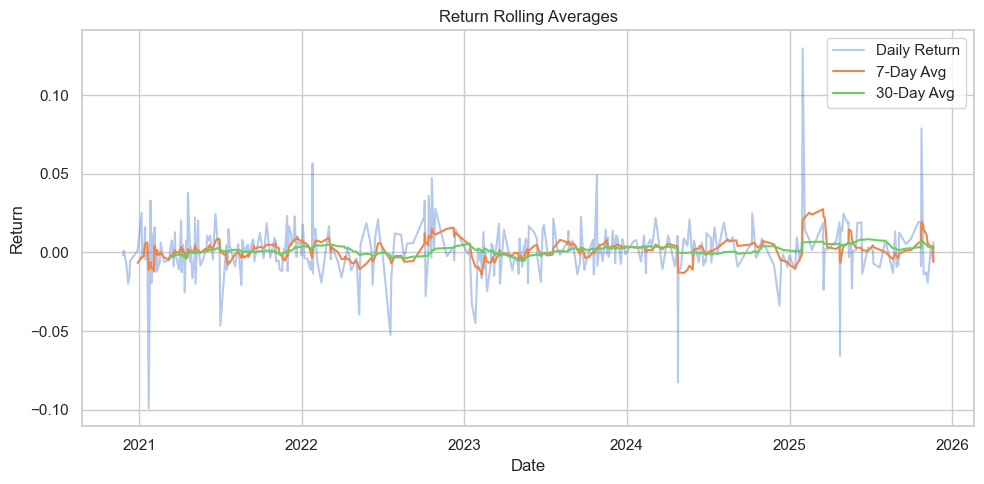

In [33]:
# Rolling averages 

# smooth out curves 
df['Return_7d'] = df['Return'].rolling(7).mean()
df['Return_30d'] = df['Return'].rolling(30).mean()
df['Interest_7d'] = df['Interest'].rolling(7).mean()
df['Sentiment_7d'] = df['Sentiment'].rolling(7).mean()


plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Return'], label='Daily Return', alpha=0.4)
plt.plot(df['Date'], df['Return_7d'], label='7-Day Avg')
plt.plot(df['Date'], df['Return_30d'], label='30-Day Avg')
plt.title("Return Rolling Averages")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()


# plt.savefig("results/close_rolling_avg.png")


Feature Engineering


Modeling